In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from collections import deque
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('macro_data_monthly.csv', parse_dates=['Date'], index_col='Date')

### Exploratory Data Analysis

In [4]:
# Display basic info
print("Data Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 534 entries, 1981-01-31 to 2025-06-30
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   10Y_Treasury_Yield  534 non-null    float64
 1   CPI                 534 non-null    float64
 2   Fed_Funds_Rate      534 non-null    float64
 3   GDP                 534 non-null    float64
 4   Inflation_Sticky    534 non-null    float64
 5   M2_Money_Supply     534 non-null    float64
 6   Unemployment Rate   534 non-null    float64
 7   Inflation           534 non-null    float64
dtypes: float64(8)
memory usage: 37.5 KB
None

Summary Statistics:
       10Y_Treasury_Yield         CPI  Fed_Funds_Rate           GDP  \
count          534.000000  534.000000      534.000000    534.000000   
mean             5.498258  188.120288        4.222528  12671.629736   
std              3.234940   60.868958        3.707838   7179.378796   
min              0.550000

In [5]:
data.head()

,10Y_Treasury_Yield,CPI,Fed_Funds_Rate,GDP,Inflation_Sticky,M2_Money_Supply,Unemployment Rate,Inflation
Date,,,,,,,,
1981-01-31,12.68,87.2,19.08,3124.206,12.018101,1599.8,7.5,12.35
1981-02-28,13.43,88.0,15.93,3124.206,11.229271,1609.0,7.4,11.79
1981-03-31,13.13,88.6,14.70,3124.206,10.319341,1637.5,7.4,10.61
1981-04-30,14.11,89.1,15.72,3162.532,9.710597,1657.1,7.2,10.14
1981-05-31,13.50,89.7,18.52,3162.532,9.603161,1648.4,7.5,10.14


In [6]:
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1

In [8]:
data['10Y_Treasury_Yield'] = (data['10Y_Treasury_Yield'] / 100) + 1

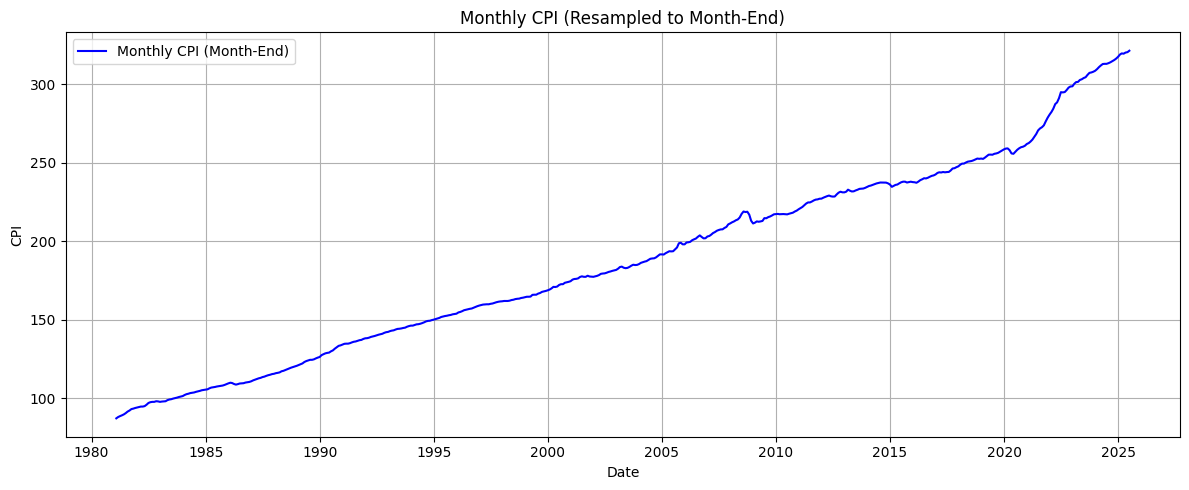

In [12]:
# Resample CPI to Month-End (last value of each month)
monthly_cpi = data['CPI'].resample('ME').last()

# Plot resampled CPI
plt.figure(figsize=(12, 5))
sns.lineplot(x=monthly_cpi.index, y=monthly_cpi.values, label='Monthly CPI (Month-End)', color='blue')
plt.title('Monthly CPI (Resampled to Month-End)')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Calculate monthly rate of change (as %)
data['CPI_Rate_Change'] = data['CPI'].pct_change() * 100

# Drop the first row if needed (because of NaN from pct_change)
data = data.dropna(subset=['CPI_Rate_Change'])


C:\Users\steve\AppData\Local\Temp\ipykernel_29548\2016439849.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').mean()


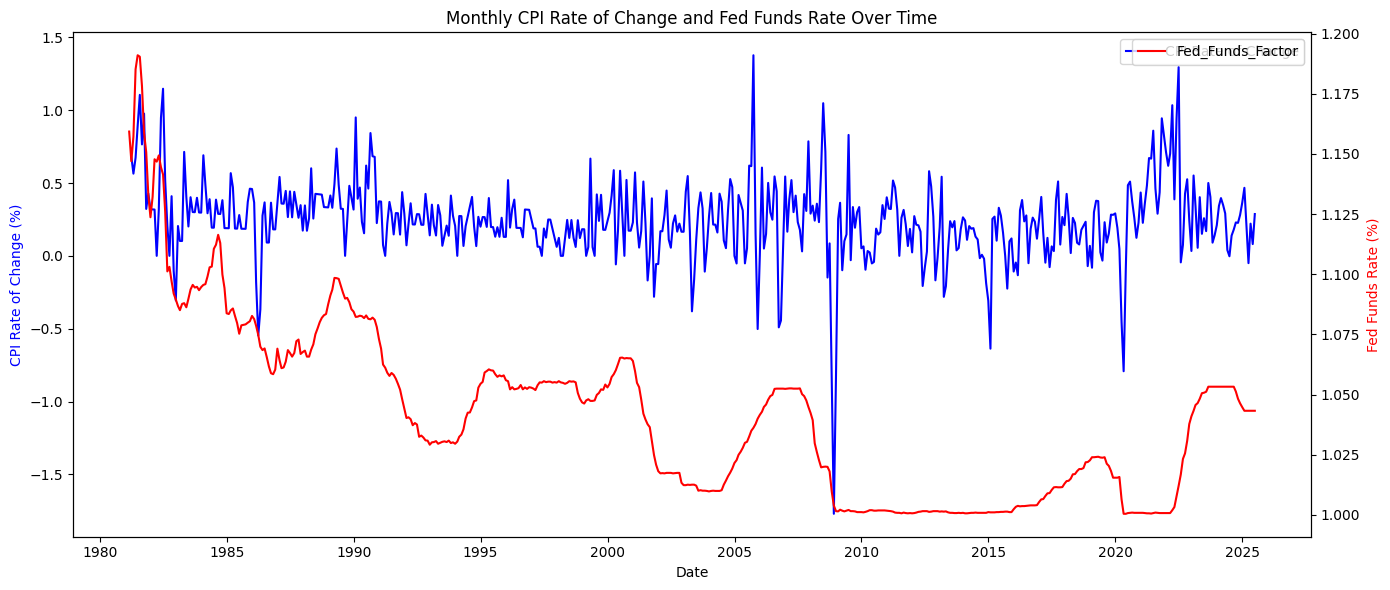

In [15]:
# Resample to monthly average
monthly_data = data.resample('M').mean()

# Calculate month-to-month CPI rate of change (%)
monthly_data['CPI_Rate_Change'] = monthly_data['CPI'].pct_change() * 100

# Create the plot
plt.figure(figsize=(14, 6))

# Plot CPI Rate of Change
ax1 = sns.lineplot(x=monthly_data.index, y=monthly_data['CPI_Rate_Change'], color='blue', label='CPI Rate of Change')
ax1.set_ylabel('CPI Rate of Change (%)', color='blue')
ax1.set_xlabel('Date')

# Plot Fed Funds Rate on secondary Y-axis
ax2 = ax1.twinx()
sns.lineplot(x=monthly_data.index, y=monthly_data['Fed_Funds_Factor'], color='red', ax=ax2, label='Fed_Funds_Factor')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')

# Title and layout
plt.title('Monthly CPI Rate of Change and Fed Funds Rate Over Time')
plt.tight_layout()
plt.show()

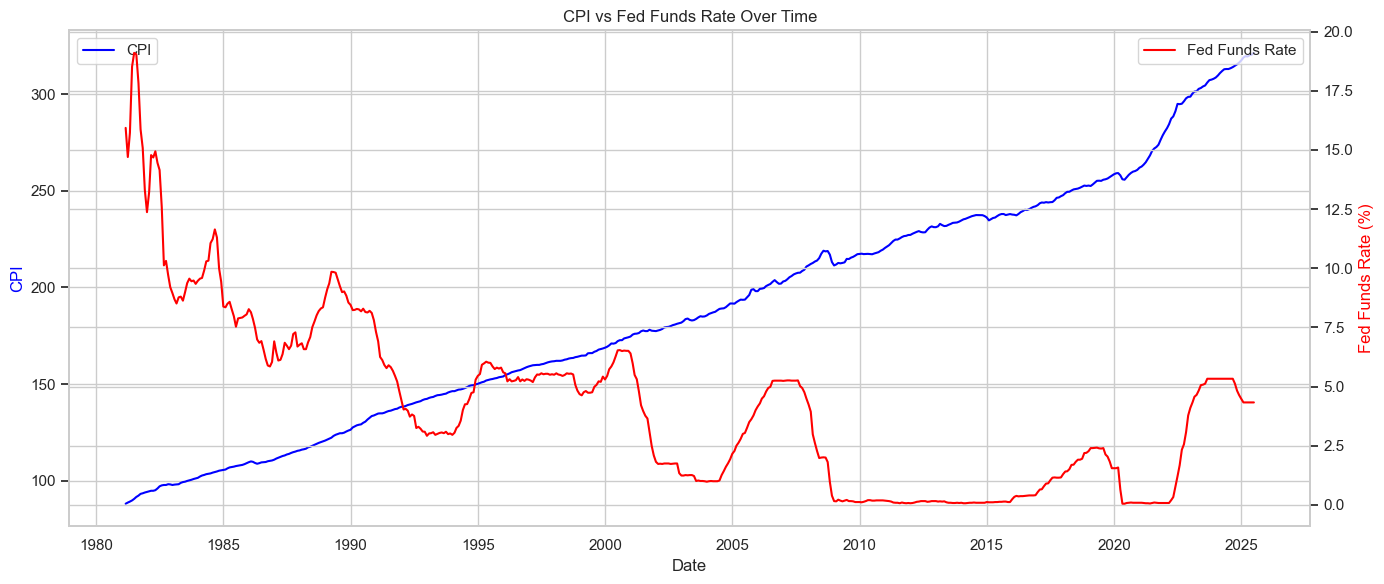

In [17]:
# Plot CPI and Fed Funds Rate
plt.figure(figsize=(14, 6))

# Plot CPI
ax1 = sns.lineplot(x=data.index, y=data['CPI'], color='blue', label='CPI')
ax1.set_ylabel('CPI', color='blue')
ax1.set_xlabel('Date')

# Plot Fed Funds Rate on secondary Y-axis
ax2 = ax1.twinx()
sns.lineplot(x=data.index, y=data['Fed_Funds_Rate'], color='red', ax=ax2, label='Fed Funds Rate')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')

# Title and layout
plt.title('CPI vs Fed Funds Rate Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

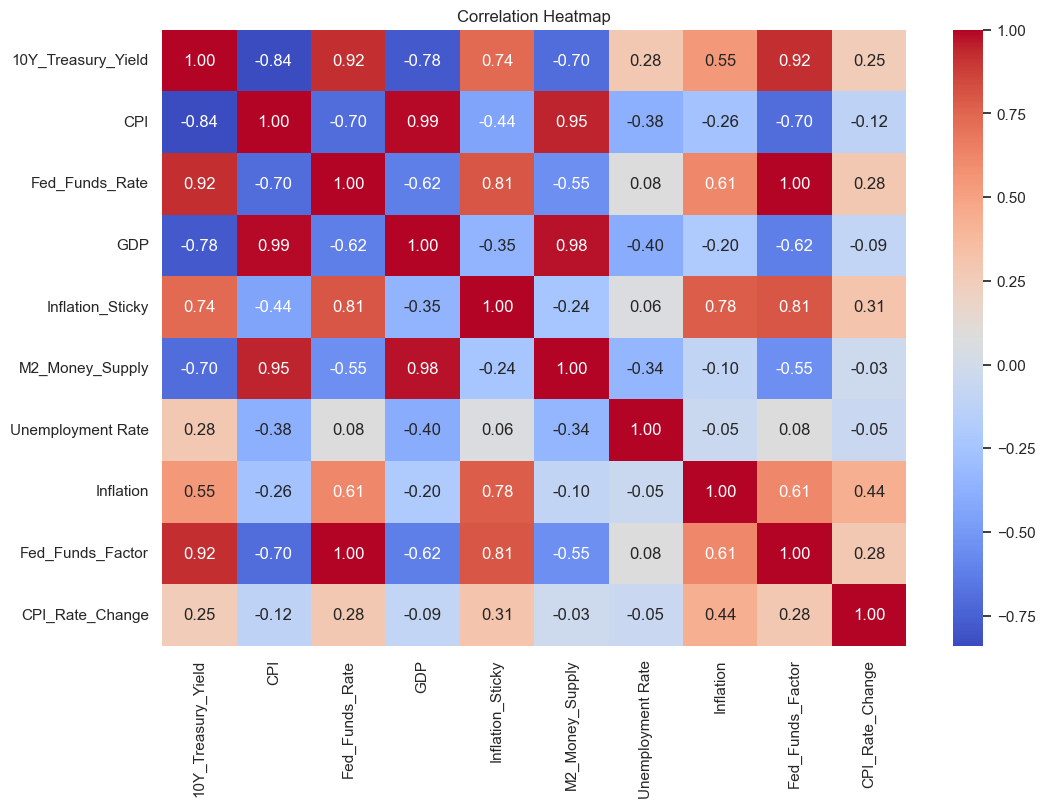

In [18]:
# Correlation heatmap (for numeric columns)
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### Model Comparison

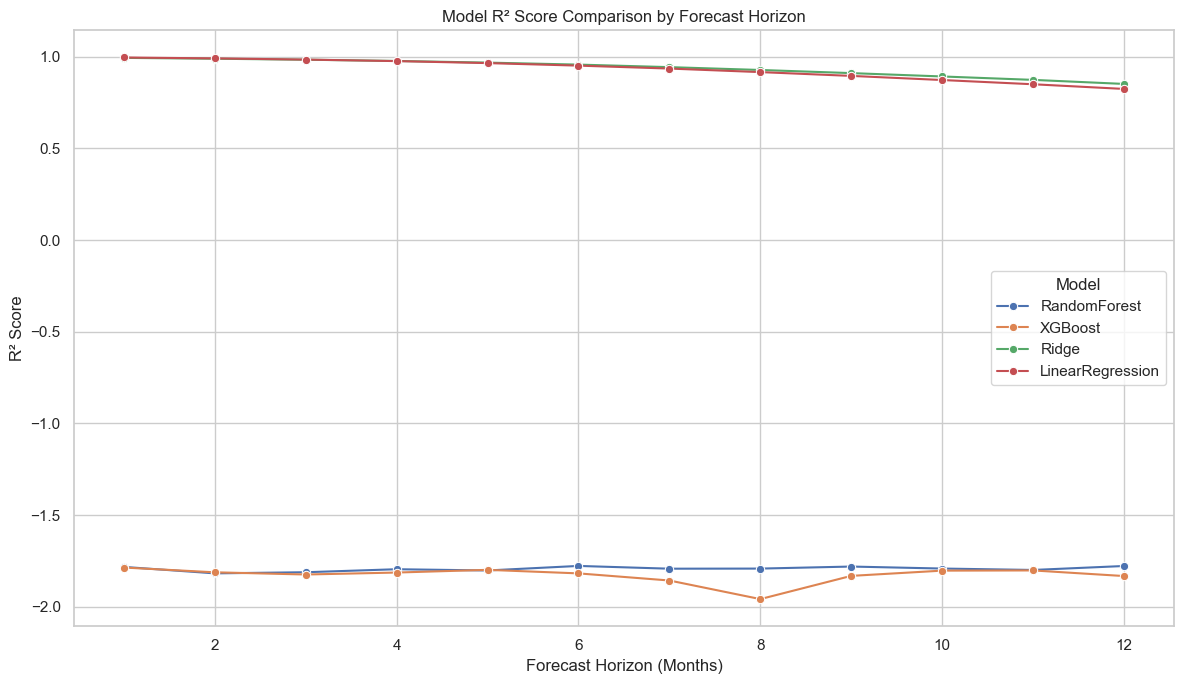

In [38]:
data = data[data['CPI'].notna()]
# Step 1: Calculate CPI rate of change (annualized from daily data)
data['CPI_Rate'] = data['CPI'].pct_change(periods=30) * 12 * 100  # monthly % change, annualized

# Step 2: Define Real Interest Rate
data['Real_Fed_Funds_Rate'] = data['Fed_Funds_Rate'] - data['CPI_Rate']
data['CPI_change'] = data['CPI'].pct_change(periods=30) * 100

# Feature engineering
data['CPI_lag30'] = data['CPI'].shift(30)
data['CPI_lag60'] = data['CPI'].shift(60)
data['Fed_Funds_Rate_lag1'] = data['Fed_Funds_Rate'].shift(1)
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)
data['Unemployment_lag1'] = data['Unemployment Rate'].shift(1)

features = [
    'Fed_Funds_Factor', 'FedFundsFactor_lag1',
    'M2_Money_Supply', 'M2_lag1',
    '10Y_Treasury_Yield',
    'CPI_lag30', 'CPI_lag60',  # << Replacing CPI_lag1
    'GDP_lag1', 'Inflation_Sticky_lag1'
]

# Models to compare
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),  # no scaling
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42),  # no scaling
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),  # with scaling
    "LinearRegression": make_pipeline(StandardScaler(), LinearRegression())  # with scaling
}
results = []

# Forecast horizon from 1 to 12 months
for horizon in range(1, 13):
    target_col = f'CPI_t_plus_{horizon}'
    data[target_col] = data['CPI'].shift(-horizon)

    df = data[feature_cols + [target_col]].dropna()
    X = df[feature_cols]
    y = df[target_col]

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Horizon": horizon,
            "Model": model_name,
            "MSE": round(mse, 2),
            "R2": round(r2, 4)
        })

# Results DataFrame
comparison_df = pd.DataFrame(results)

# Plot R² score comparison
plt.figure(figsize=(12, 7))
sns.lineplot(data=comparison_df, x="Horizon", y="R2", hue="Model", marker="o")
plt.title("Model R² Score Comparison by Forecast Horizon")
plt.ylabel("R² Score")
plt.xlabel("Forecast Horizon (Months)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Linear Regression

In [45]:
data = data[data['CPI'].notna()]

# --- 2. Feature Engineering ---
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1
data['CPI_lag1'] = data['CPI'].shift(1)
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)
data['FedFundsFactor_lag1'] = data['Fed_Funds_Factor'].shift(1)
data['CPI_1mo_ahead'] = data['CPI'].shift(-1)

features_1mo = [
    'Fed_Funds_Factor',
    'FedFundsFactor_lag1',
    'M2_Money_Supply',
    'M2_lag1',
    '10Y_Treasury_Yield',
    'CPI_lag1'
]

# --- 3. Model Preparation ---
df_model = data[features_1mo + ['CPI_1mo_ahead']].dropna()
X = df_model[features_1mo]
y = df_model['CPI_1mo_ahead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_1mo = make_pipeline(StandardScaler(), LinearRegression())
model_1mo.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [53]:
# --- 4. Model Evaluation ---
y_pred = model_1mo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"1-Month Ahead CPI Forecast - Evaluation:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.4f}")

1-Month Ahead CPI Forecast - Evaluation:
Mean Squared Error: 0.864
R² Score: 0.9998


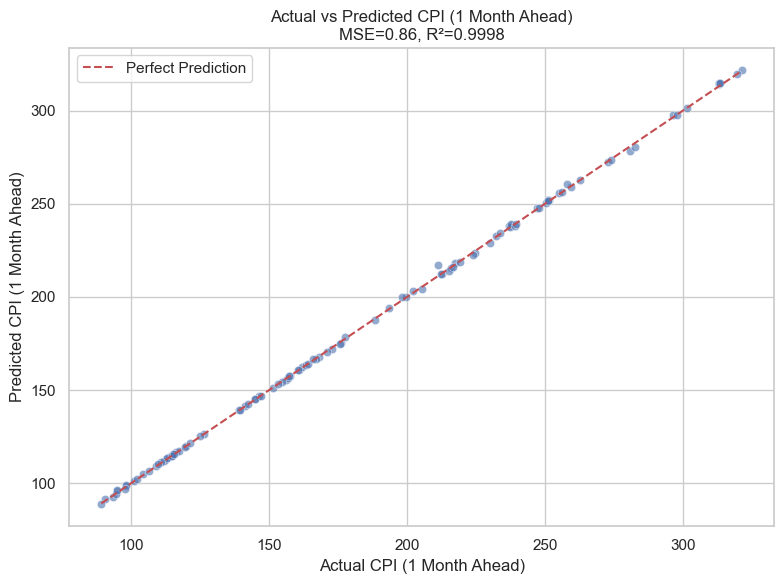

In [54]:
# --- 5. Actual vs Predicted Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual CPI (1 Month Ahead)")
plt.ylabel("Predicted CPI (1 Month Ahead)")
plt.title(f"Actual vs Predicted CPI (1 Month Ahead)\nMSE={mse:.2f}, R²={r2:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_29548\991228344.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_29548\991228344.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_29548\991228344.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_cpi = past_cpi[-1]


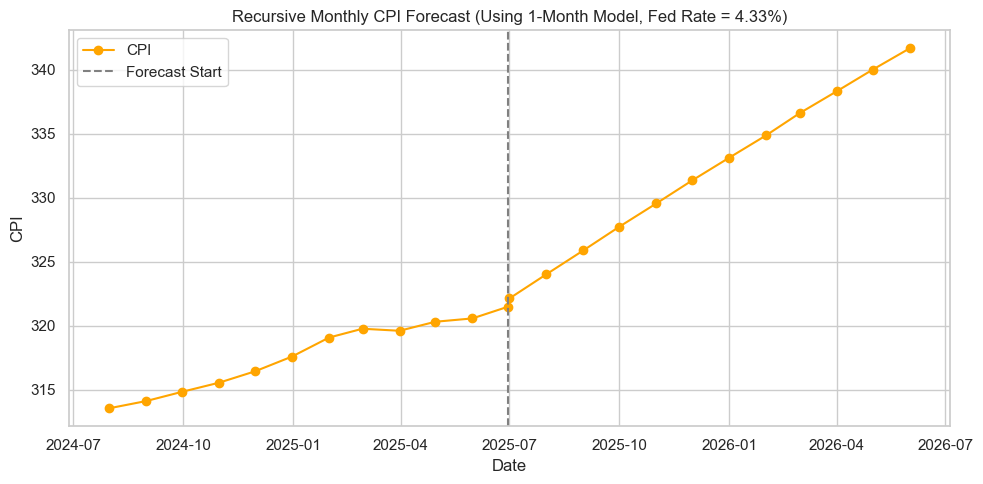

In [57]:
# --- 4. Forecast Setup ---
last_date = data.index.max()
past_cpi = data['CPI'].dropna().last('12M')
initial_cpi = past_cpi[-1]

fed_rate = 4.33
fed_factor = (fed_rate / 100) + 1
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_cpi = []

# --- 5. Forecast Logic ---
last_real_input = X.iloc[[-1]]
first_pred = model_1mo.predict(last_real_input)[0]
forecast_cpi.append(first_pred)

cpi_lag1 = first_pred
m2_lag1 = m2

for _ in range(11):
    input_df = pd.DataFrame([{
        'Fed_Funds_Factor': fed_factor,
        'FedFundsFactor_lag1': fed_factor,
        'M2_Money_Supply': m2,
        'M2_lag1': m2_lag1,
        '10Y_Treasury_Yield': treasury_yield,
        'CPI_lag1': cpi_lag1
    }])

    pred_cpi = model_1mo.predict(input_df)[0]
    forecast_cpi.append(pred_cpi)
    cpi_lag1 = pred_cpi
    m2_lag1 = m2

# --- 6. Plotting ---
combined_dates = past_cpi.index.append(forecast_dates)
combined_cpi = past_cpi.tolist() + forecast_cpi

plt.figure(figsize=(10, 5))
plt.plot(combined_dates, combined_cpi, marker='o', color='orange', label='CPI')
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("Recursive Monthly CPI Forecast (Using 1-Month Model, Fed Rate = 4.33%)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

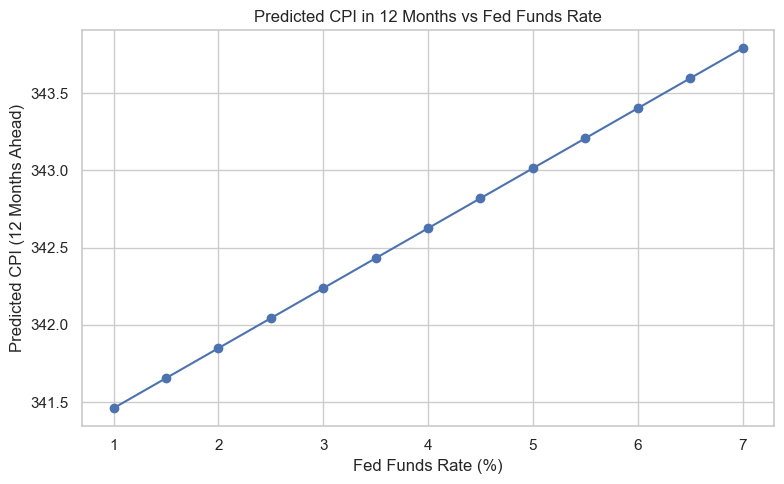

In [58]:
# --- Setup for Simulation ---
rates = np.arange(1.0, 7.1, 0.5)  # Fed Funds Rate from 1.0% to 7.0%
forecast_horizon = 12  # months ahead

# Latest known values
initial_cpi = data['CPI'].dropna().iloc[-1]
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# Store final CPI forecasts
predicted_cpi_12mo = []

for rate in rates:
    fed_factor = (rate / 100) + 1
    cpi_lag1 = initial_cpi
    m2_lag1 = m2
    forecast_cpi = []

    for _ in range(forecast_horizon):
        input_df = pd.DataFrame([{
            'Fed_Funds_Factor': fed_factor,
            'FedFundsFactor_lag1': fed_factor,
            'M2_Money_Supply': m2,
            'M2_lag1': m2_lag1,
            '10Y_Treasury_Yield': treasury_yield,
            'CPI_lag1': cpi_lag1
        }])

        pred_cpi = model_1mo.predict(input_df)[0]
        forecast_cpi.append(pred_cpi)
        cpi_lag1 = pred_cpi  # update for next iteration

    predicted_cpi_12mo.append(forecast_cpi[-1])  # store final forecasted CPI

# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(rates, predicted_cpi_12mo, marker='o')
plt.title("Predicted CPI in 12 Months vs Fed Funds Rate")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Predicted CPI (12 Months Ahead)")
plt.grid(True)
plt.tight_layout()
plt.show()


